# Title: MVP 3

Name:- Ankila Kumari| 
Email:- Kuma0389@umn.edu


## 1. Design Framework

### 1.1. Problem Statement
Access to public libraries is essential for community engagement and education. However, there is a lack of visual tools that combine environmental data with library locations to support planning and outreach efforts.

### 1.2. Solution
The comprehensive solution would involve an interactive platform that overlays environmental indicators, like NDVI (Normalized Difference Vegetation Index), with public library locations. This platform would provide insights into environmental conditions around libraries, aiding in decision making for community services and environmental planning.

### 1.3. Challenge
The main challenge in creating the MVP is integrating geospatial environmental data with accurate library location data in a user friendly interface. Ensuring data accuracy and real time updates adds complexity to the development process.

### 1.4 Spec list


  * Value: (H)igh, (M)edium, (L)ow
  * Effort: (H)igh, (M)edium, (L)ow
  * Feature: Brief description of the feature


| Value | Effort  | Feature    |
|:------|:------|:-----------|
|H     |L     |Ability to read and tile multiple GeoTIFF files |
|H     |M     |Filter out blank (all-zero) GeoTIFF files |
|H     |M     |Geocode library addresses with rate limiting |
|H     |M     |Visualize library locations on a static map |
|H     |M     |Display NDVI data on an interactive map |
|M     |M     |Integrate NDVI data with library locations for environmental insights |
|M     |L     |Export processed data to CSV or GeoJSON for further analysis |
|M     |M     |Implement error handling for geocoding failures |
|L     |H     |Develop a web-based dashboard for real-time data visualization |
|L     |H     |Incorporate GeoAI for predictive analysis of library accessibility |


___

# 2. Minimal Viable Product

## 2.1. Setup & Installation

In the code cell below, you will write all your import and load statements for the packages and data needed for your project.

In [1]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension --sys-prefix


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import geemap
import ee
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

/opt/conda/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [3]:

# Initialize Earth Engine
ee.Initialize()


## 2.2. Functions
This section defines all functions that will be used in your MVP and Project.

### Pre-processing functions

In [4]:
# Pre-processing function to get NDVI
def get_ndvi_image(geometry):
    """Calculate NDVI from Sentinel-2 imagery in GEE"""
    s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterDate('2023-05-01', '2023-08-31') \
    .filterBounds(geometry) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
    .median()

    ndvi = s2.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return ndvi.clip(geometry)

## 2.3. Execute your code. Let's go
These code cells will actually make your code run. Up until now you have only imported modules and defined modules.
This is where you start running code, passing variables, and creating maps, plots, and analytical results.

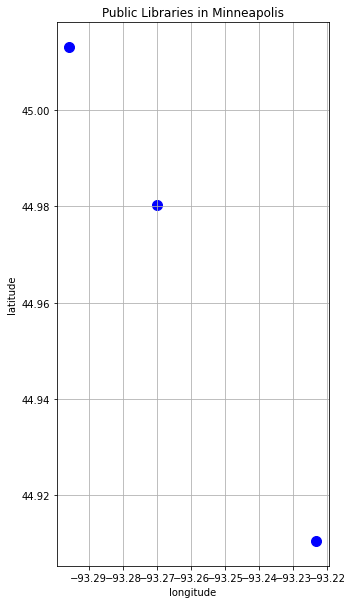

In [5]:
# 2.3. Execute your code. Let's go

mn_shape = gpd.read_file('data/tl_2022_27_tabblock20.zip')  # Replace with your actual file
mn_ee_geom = geemap.geopandas_to_ee(mn_shape)  # Convert to EE geometry
# Define area of interest (Minneapolis example)
minneapolis = ee.Geometry.Point([-93.2650, 44.9778]).buffer(5000)  # 5km buffer

# Get NDVI data
ndvi_image = get_ndvi_image(minneapolis)

# Load library data
data = {
    'Library': ['Central Library', 'Nokomis Library', 'North Regional Library'],
    'Address': ['300 Nicollet Mall, Minneapolis, MN',
                '5100 34th Ave S, Minneapolis, MN',
                '1315 Lowry Ave N, Minneapolis, MN']
}
df = pd.DataFrame(data)

# Geocode addresses with rate limiting
geolocator = Nominatim(user_agent="mpls_library_mapper", timeout=10)
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Apply geocoding
def get_coordinates(address):
    try:
        location = geocode(address)
        if location:
            return pd.Series([location.latitude, location.longitude])
        else:
            return pd.Series([None, None])
    except Exception as e:
        print(f"Error geocoding {address}: {e}")
        return pd.Series([None, None])

df[['latitude', 'longitude']] = df['Address'].apply(get_coordinates)

# Drop rows with missing coordinates
df.dropna(subset=['latitude', 'longitude'], inplace=True)

# Create GeoDataFrame
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Plotting the map
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='blue', markersize=100)
plt.title('Public Libraries in Minneapolis')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.grid(True)
plt.show()

# Displaying the map using geemap
Map = geemap.Map(center=[44.9778, -93.2650], zoom=12)
Map.addLayer(ndvi_image, {'min': 0, 'max': 1, 'palette': ['white', 'green']}, 'NDVI')
Map.add_points_from_xy(df, x_column='longitude', y_column='latitude', layer_name='Libraries')
Map.to_html("ndvi_libraries_map.html")


## 2.4. Rationale
Why is this an MVP?

This project qualifies as a Minimum Viable Product (MVP) because it delivers the core functionality needed to address the identified problem: mapping public library locations alongside environmental data. By focusing on essential features such as data integration, geocoding, and basic visualization it allows for early testing and feedback. This approach ensures  that resources are used efficiently, and future developments are guided by actual user needs and responses, aligning with the principles of MVP development .​

In [7]:
from IPython.display import HTML

HTML('<a href="ndvi_libraries_map.html" target="_blank">Click here to open the NDVI map</a>')

